In [16]:
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

from peak_modeling import *
from radiation import obs_arrays
from run_analysis import get_peaks_from_data
import matplotlib.pyplot as plt
plt.ion()

model1 = peaks_model_R24
model2 = peaks_model_plaws
model3 = peaks_model_C25

In [2]:
def plot_output(T, model, ax, *args, **kwargs):
  nu, nF = model(T, *args)
  ax.loglog(nu, nF, **kwargs)

def create_legend_colors(ax, names, colors, **kwargs):
  dummy_col = [ax.plot([], [], c=col, ls='-')[0] for col in colors]
  legend = ax.legend(dummy_col, names, **kwargs)
  return legend

def create_legend_styles(ax, names, styles, **kwargs):
  dummy_lst = [ax.plot([], [], c='k', ls=l)[0] for l in styles]
  legend = ax.legend(dummy_lst, names, **kwargs)
  return legend

We test the various models for observed peak frequency and flux in the different models and compare them with data from our simulation

### Data:
observed peaks from fiducial run in spherical geometry

In [18]:
nu, T, env = obs_arrays('sph_fid', normed=True)
nu_pk, nF_pk = get_peaks_from_data('sph_fid', 'RS')
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_title('Data from fiducial run')
ax1.semilogy(T, nu_pk, c='r')
ax1.set_ylabel('$\\nu_{\\rm pk}/\\nu_0$')
ax2.plot(T, nF_pk, c='r')
ax2.set_ylabel('$(\\nu F_\\nu)_{\\rm pk}/\\nu_0F_0$')
ax2.set_xlabel('$\\tilde{T}$')

Text(0.5, 0, '$\\tilde{T}$')

### Model1: Rahaman et al. 2024b
This model assumes constant Lorentz factor of the emitting region and constant energy dissipation in the shock

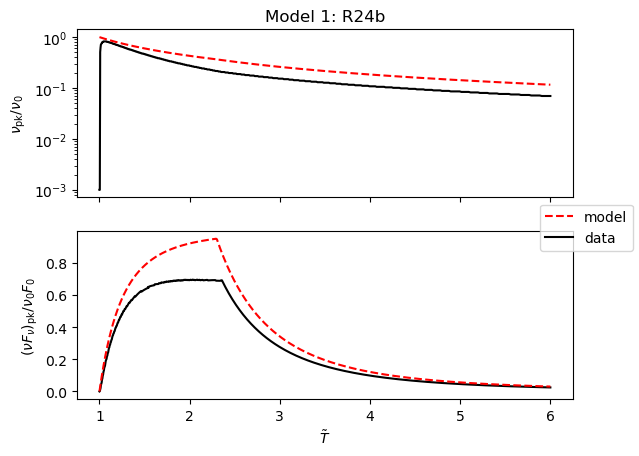

In [4]:
T = np.geomspace(1, 6, 450)
nu, nF = model1(T, 2, 1.3)
fig = plt.figure()
gs = fig.add_gridspec(2, 1, wspace=0)
ax1, ax2 = gs.subplots(sharex='all')
ax1.set_title('Model 1: R24b')
ax1.semilogy(T, nu_pk, c='k')
ax1.semilogy(T, nu, c='r', ls='--', label='model')
ax1.set_ylabel('$\\nu_{\\rm pk}/\\nu_0$')
ax2.plot(T, nF_pk, c='k', label='data')
ax2.plot(T, nF, c='r', ls='--')
ax2.set_ylabel('$(\\nu F_\\nu)_{\\rm pk}/\\nu_0F_0$')
ax2.set_xlabel('$\\tilde{T}$')
fig.legend(loc='center right')

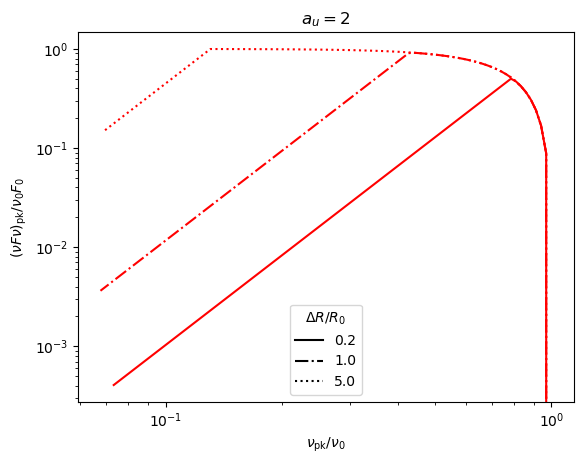

In [5]:
T = np.geomspace(1, 10, 100)
dRs = [0.2, 1, 5]
lstyles = ['-', '-.', ':']
fig, ax = plt.subplots()
ax.set_xlabel('$\\nu_{\\rm pk}/\\nu_0$')
ax.set_ylabel('$(\\nu F\\nu)_{\\rm pk}/\\nu_0F_0$')
ax.set_title('$a_u=2$')
legend = create_legend_styles(ax, [f'{dR:.1f}' for dR in dRs], lstyles,
    title='$\\Delta R/R_0$')

for dR, ls in zip(dRs, lstyles):
  plot_output(T, model1, ax, 2, dR, c='r', ls=ls)


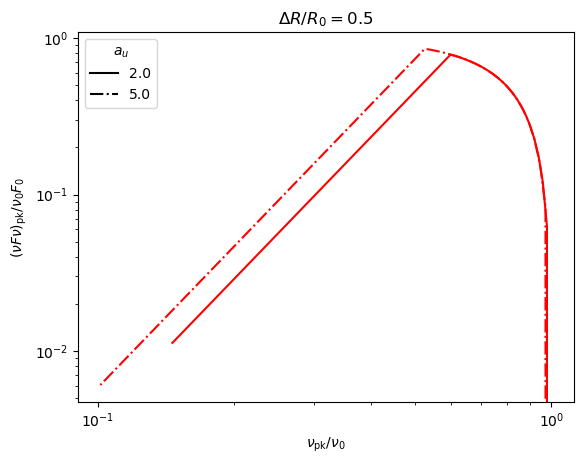

In [6]:
T = np.geomspace(1, 5, 100)
aus = [2, 5]
lstyles = ['-', '-.']
fig, ax = plt.subplots()
ax.set_xlabel('$\\nu_{\\rm pk}/\\nu_0$')
ax.set_ylabel('$(\\nu F\\nu)_{\\rm pk}/\\nu_0F_0$')
ax.set_title('$\Delta R/R_0=0.5$')
legend = create_legend_styles(ax, [f'{au:.1f}' for au in aus], lstyles,
    title='$a_u$')

for au, ls in zip(aus, lstyles):
  plot_output(T, model1, ax, au, 0.5, c='r', ls=ls)

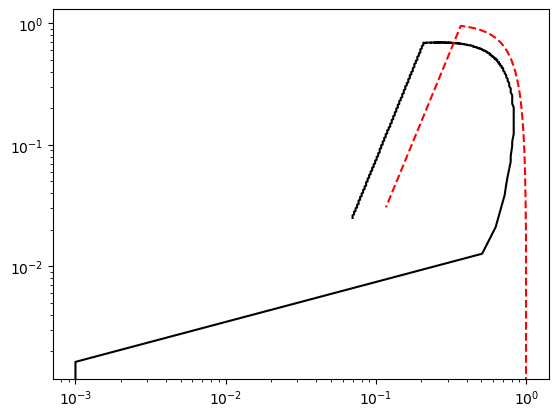

In [7]:
fig, ax = plt.subplots()
ax.loglog(nu_pk[nu_pk>0], nF_pk[nu_pk>0], c='k')
ax.loglog(nu, nF, c='r', ls='--')

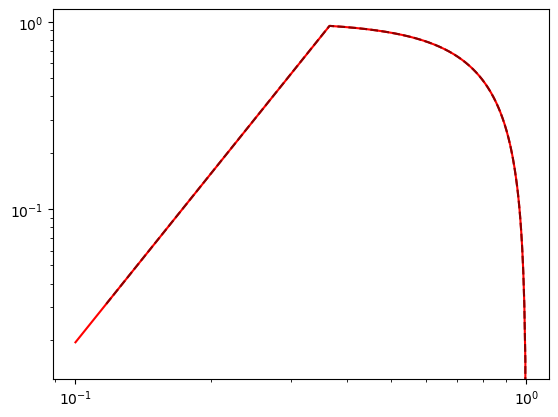

In [8]:
# quick comparison between the simplified and original version
def g2_from_au(au):
  '''
  Ratio of downstream L.F. to shock front L.F., squared
  '''

  # R24b (I1), ratio between \Gamma and \Gamma_4
  K = np.sqrt(2) / np.sqrt(1 + au*au)

  # relative LF in UR regime (Sari & Piran 95, Eq 3)
  G34 = .5 * (1/K + K)

  # plug this in R24a eqn (C5)
  # use UR approx beta = 1 - 1/(2*Gamma**2)
  qR = 4*G34*K
  gRS2 = (qR - K*K)/(qR - 1)
  return gRS2
def peaks_model(nu_pks, au, dR):
  '''
  Peak flux vs peak frequency, normalized, from the collision of UR shells
  parameters:
    nu_pks:     normalized peak observed frequency
      type np.ndarray, replace "np.where" by if/else if you prefer a float as input
    au:         a_u, proper velocity contrast
    dR:         \Delta R_f/R_0, distance crossed by the shock front, units R_0
  '''

  # downstream L.F. to shock front L.F. ratio
  g2 = g2_from_au(au)

  # break frequency
  nu_bk = 1/(1 + g2*dR)

  # model functions
  rise = (nu_pks > nu_bk)
  def flux_rise(nu):
    return 1 - nu**3
  def flux_HLE(nu):
    nF_bk = flux_rise(nu_bk)
    return nF_bk * (nu/nu_bk)**3
  nF = np.where(rise, flux_rise(nu_pks), flux_HLE(nu_pks))

  return nF

au, dR = 2, 1.3
T = np.geomspace(1, 6, 450)
nu, nF = model1(T, au, dR)
nu_2 = np.logspace(-1, 0, 450)
nF_2 = peaks_model(nu_2, au, dR)

fig, ax = plt.subplots()
ax.loglog(nu_2, nF_2, c='r')
ax.loglog(nu, nF, c='darkred', ls='--')

### Model2: Generalization
This model adds variability of LF and dissipation rate: $\Gamma^2\propto R^{-m}$, $L'_{\rm bol}\propto R^{-n}$. For now, m and n are not constrained by the model, but they are being determined by simulations over a range of parameter space. 

Reference values:
$a_u=2$:, $m=-0.32$ and $n=0.89$
$a_u=5$:, $m=-0.76$ and $n=0.86$

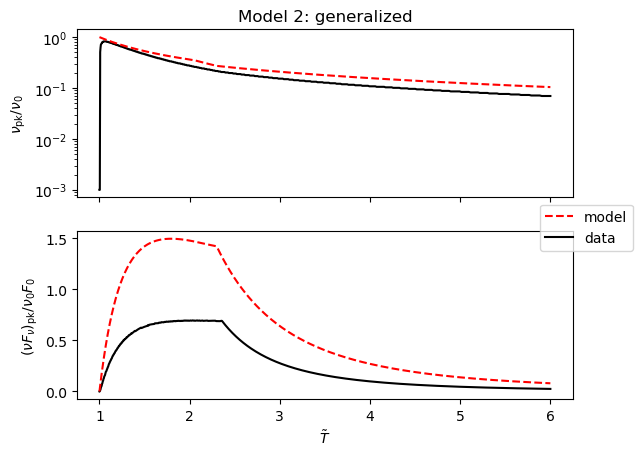

In [9]:
T = np.geomspace(1, 6, 450)
nu, nF = model2(T, 2, 1.3, -0.3, 0.5)
fig = plt.figure()
gs = fig.add_gridspec(2, 1, wspace=0)
ax1, ax2 = gs.subplots(sharex='all')
ax1.set_title('Model 2: generalized')
ax1.semilogy(T, nu_pk, c='k')
ax1.semilogy(T, nu, c='r', ls='--', label='model')
ax1.set_ylabel('$\\nu_{\\rm pk}/\\nu_0$')
ax2.plot(T, nF_pk, c='k', label='data')
ax2.plot(T, nF, c='r', ls='--')
ax2.set_ylabel('$(\\nu F_\\nu)_{\\rm pk}/\\nu_0F_0$')
ax2.set_xlabel('$\\tilde{T}$')
fig.legend(loc='center right')

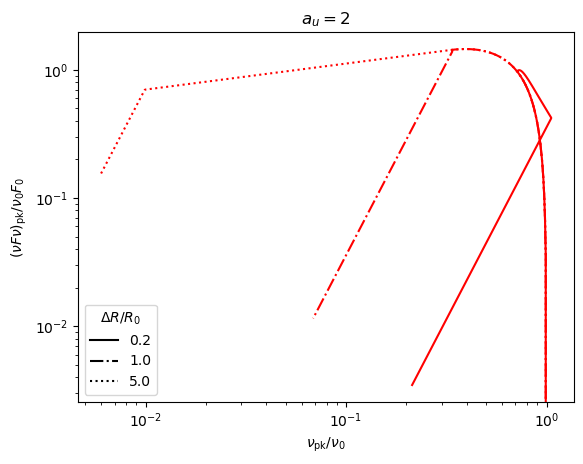

In [10]:
T = np.geomspace(1, 10, 500)
dRs = [0.2, 1, 5]
lstyles = ['-', '-.', ':']
fig, ax = plt.subplots()
ax.set_xlabel('$\\nu_{\\rm pk}/\\nu_0$')
ax.set_ylabel('$(\\nu F\\nu)_{\\rm pk}/\\nu_0F_0$')
ax.set_title('$a_u=2$')
legend = create_legend_styles(ax, [f'{dR:.1f}' for dR in dRs], lstyles,
    title='$\\Delta R/R_0$')

for dR, ls in zip(dRs, lstyles):
  plot_output(T, model2, ax, 2, dR, -0.32, 0.89, c='r', ls=ls)

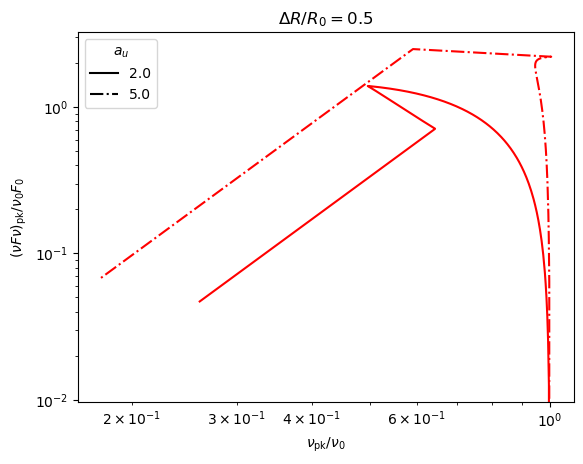

In [11]:
T = np.geomspace(1, 5, 1000)
aus, ms, ns = [2, 5], [-0.32, -0.76], [0.89, 0.86]
lstyles = ['-', '-.', ':']
fig, ax = plt.subplots()
ax.set_xlabel('$\\nu_{\\rm pk}/\\nu_0$')
ax.set_ylabel('$(\\nu F\\nu)_{\\rm pk}/\\nu_0F_0$')
ax.set_title('$\Delta R/R_0=0.5$')
legend = create_legend_styles(ax, [f'{au:.1f}' for au in aus], lstyles,
    title='$a_u$')

for au, m, n, ls in zip(aus, ms, ns, lstyles):
  plot_output(T, model2, ax, au, 0.5, m, n, c='r', ls=ls)

### Model 3: The effective angle approximation
Model of Charlet et al. 2025 (\S 3.4), simplified to take as little parameters as possible

/home/acharlet/Science/ARCO/MWN/GAMMA_MWN/bin/Tools/project_v2/peak_modeling.py:194: RuntimeWarning: divide by zero encountered in power
  xi_max = (EATS**(-s) + xi_sat**(-s))**(-1.0/s)


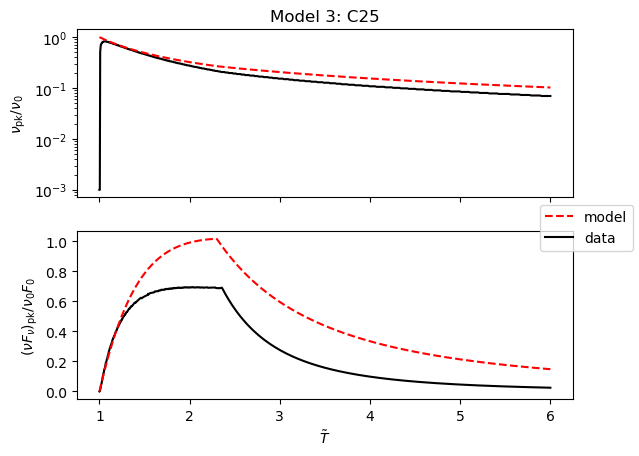

In [13]:
T = np.geomspace(1, 6, 450)
m, lfac2_sph, n, Sh_sph = -0.32, 1.16, 0.89, 0.68
nu, nF = model3(T, 2, 1.3, m, lfac2_sph, n, Sh_sph, k=0.3, xi_effmax=2.)
fig = plt.figure()
gs = fig.add_gridspec(2, 1, wspace=0)
ax1, ax2 = gs.subplots(sharex='all')
ax1.set_title('Model 3: C25')
ax1.semilogy(T, nu_pk, c='k')
ax1.semilogy(T, nu, c='r', ls='--', label='model')
ax1.set_ylabel('$\\nu_{\\rm pk}/\\nu_0$')
ax2.plot(T, nF_pk, c='k', label='data')
ax2.plot(T, nF, c='r', ls='--')
ax2.set_ylabel('$(\\nu F_\\nu)_{\\rm pk}/\\nu_0F_0$')
ax2.set_xlabel('$\\tilde{T}$')
fig.legend(loc='center right')